In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [67]:
# Đọc dữ liệu
df = pd.read_csv("/content/data.csv")

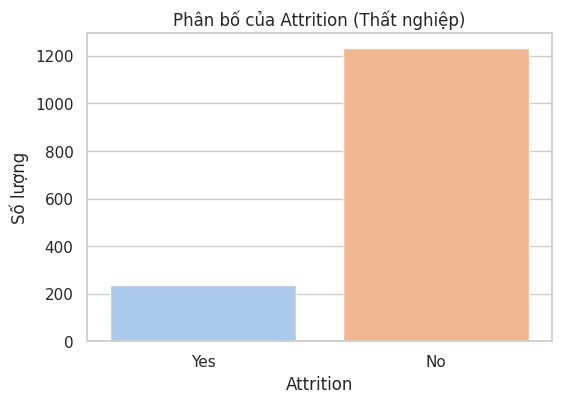

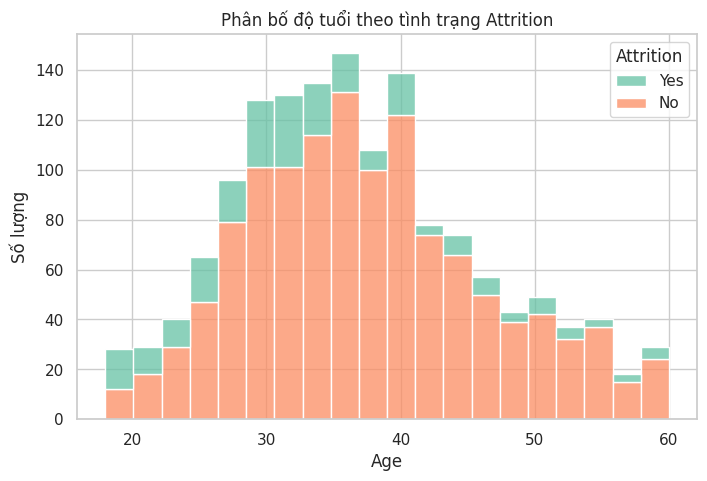

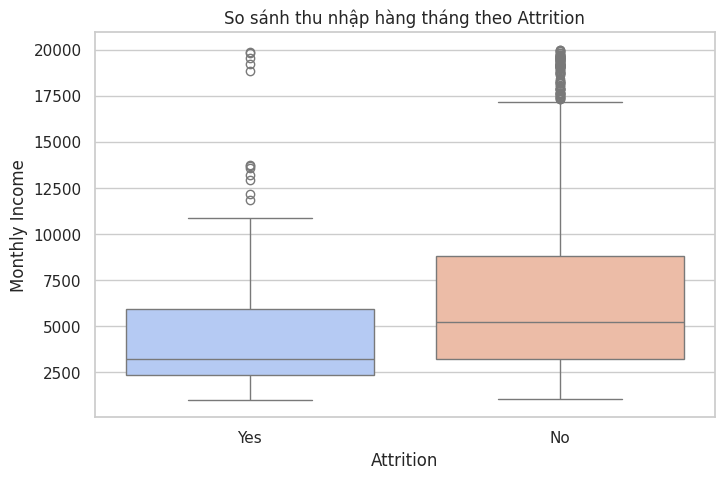

In [68]:
# Trực quan hóa dữ liệu
# Cài đặt kiểu cho biểu đồ
sns.set(style="whitegrid")

# Biểu đồ phân bố Attrition
plt.figure(figsize=(6,4))
sns.countplot(x="Attrition", data=df, hue="Attrition", palette="pastel", legend=False)
plt.title("Phân bố của Attrition (Thất nghiệp)")
plt.xlabel("Attrition")
plt.ylabel("Số lượng")
plt.show()

# Biểu đồ phân bố độ tuổi theo Attrition
plt.figure(figsize=(8,5))
sns.histplot(df, x="Age", hue="Attrition", multiple="stack", bins=20, palette="Set2")
plt.title("Phân bố độ tuổi theo tình trạng Attrition")
plt.xlabel("Age")
plt.ylabel("Số lượng")
plt.show()

# Biểu đồ hộp so sánh thu nhập theo Attrition
plt.figure(figsize=(8,5))
sns.boxplot(x="Attrition", y="MonthlyIncome", data=df, hue="Attrition", palette="coolwarm", dodge=False)
plt.title("So sánh thu nhập hàng tháng theo Attrition")
plt.xlabel("Attrition")
plt.ylabel("Monthly Income")
plt.show()

In [69]:
# Xóa các cột không cần thiết
df.drop(columns=["EmployeeCount", "EmployeeNumber", "StandardHours", "Over18"], inplace=True)

# Kiểm tra và xử lý missing values
df.dropna(inplace=True)  # Loại bỏ các dòng có giá trị thiếu

# Loại bỏ dữ liệu trùng lặp
df.drop_duplicates(inplace=True)

# Kiểm tra và chuyển đổi kiểu dữ liệu phù hợp
df = df.convert_dtypes()

# Xử lý outliers bằng IQR
def remove_outliers(df, cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df

df = remove_outliers(df, df.select_dtypes(include=['int64', 'float64']).columns)

In [70]:
# Mã hóa biến mục tiêu
le_attrition = LabelEncoder()
df["Attrition"] = le_attrition.fit_transform(df["Attrition"])

# Mã hóa các biến phân loại
categorical_cols = ["BusinessTravel", "Department", "EducationField", "Gender", "JobRole", "MaritalStatus", "OverTime"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [71]:
# Chuẩn hóa dữ liệu số
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop("Attrition")
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Chia tập dữ liệu
X = df.drop(columns=["Attrition"])
y = df["Attrition"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [72]:
# Callback để tránh overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5847 - loss: 0.6963 - val_accuracy: 0.8077 - val_loss: 0.4830
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8346 - loss: 0.4327 - val_accuracy: 0.8269 - val_loss: 0.4494
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8296 - loss: 0.4036 - val_accuracy: 0.8269 - val_loss: 0.4309
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8423 - loss: 0.4046 - val_accuracy: 0.8269 - val_loss: 0.4179
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8674 - loss: 0.3483 - val_accuracy: 0.8397 - val_loss: 0.4141
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8685 - loss: 0.3304 - val_accuracy: 0.8590 - val_loss: 0.4089
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8669 - loss: 0.3447 - val_accuracy: 0.8590 - val_loss: 0.4091
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8739 - loss: 0.3448 - val_accuracy: 0.8654 - val_loss

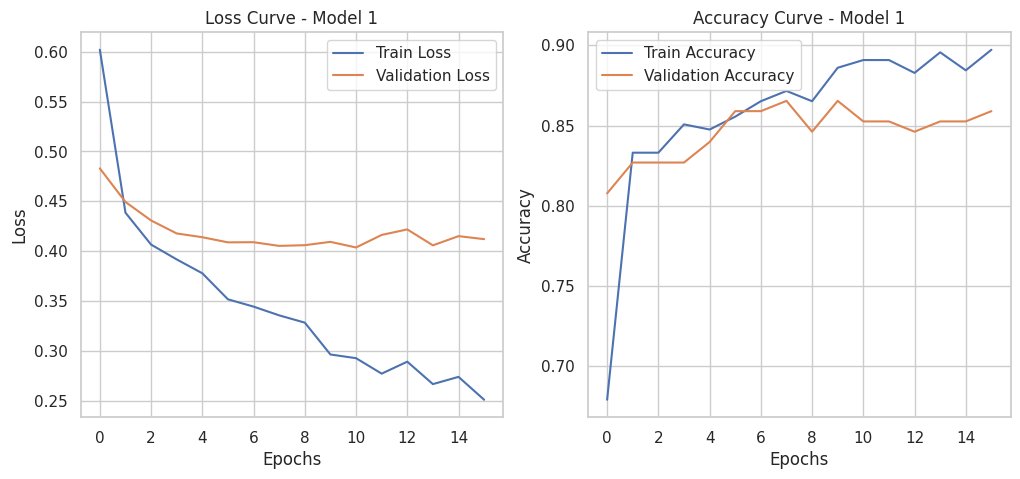

In [73]:
# Xây dựng mô hình ANN
# Mô hình 1 với Dropout (64-32 relu + Dropout)
model_1 = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compile mô hình
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
history_1 = model_1.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

# Đánh giá mô hình
loss, accuracy = model_1.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy trên tập kiểm tra: {accuracy:.4f}")

# Vẽ biểu đồ loss và accuracy cho model_1
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve - Model 1')

plt.subplot(1, 2, 2)
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve - Model 1')
plt.show()

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7077 - loss: 0.5956 - val_accuracy: 0.8205 - val_loss: 0.4713
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8231 - loss: 0.4559 - val_accuracy: 0.8205 - val_loss: 0.4362
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8202 - loss: 0.4254 - val_accuracy: 0.8269 - val_loss: 0.4186
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8469 - loss: 0.3708 - val_accuracy: 0.8269 - val_loss: 0.4126
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8379 - loss: 0.3853 - val_accuracy: 0.8269 - val_loss: 0.4123
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8376 - loss: 0.3745 - val_accuracy: 0.8397 - val_loss: 0.4229
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8332 - loss: 0.3705 - val_accuracy: 0.8333 - val_loss: 0.4153
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8690 - loss: 0.3245 - val_accuracy: 0.8462 - val_loss

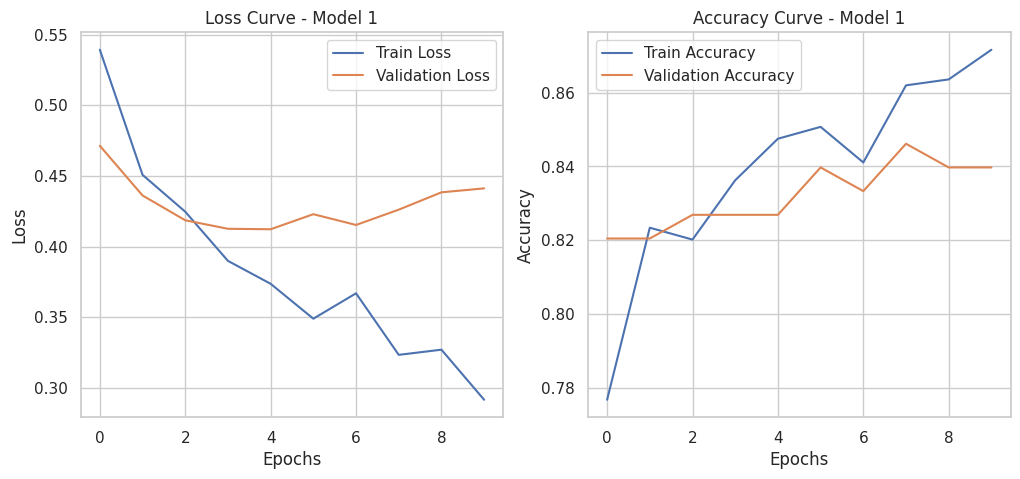

In [74]:
# Mô hình thứ hai với nhiều lớp hơn và Dropout (128-64-32 relu + Dropout)
model_2 = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile mô hình
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
history_2 = model_2.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

# Đánh giá mô hình
loss, accuracy = model_2.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy trên tập kiểm tra: {accuracy:.4f}")

# Vẽ biểu đồ loss và accuracy cho model_1
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve - Model 1')

plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve - Model 1')
plt.show()

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6098 - loss: 0.6824 - val_accuracy: 0.8269 - val_loss: 0.4828
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7831 - loss: 0.4863 - val_accuracy: 0.8462 - val_loss: 0.3937
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8290 - loss: 0.4214 - val_accuracy: 0.8462 - val_loss: 0.3747
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8280 - loss: 0.4192 - val_accuracy: 0.8462 - val_loss: 0.3769
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8527 - loss: 0.3398 - val_accuracy: 0.8526 - val_loss: 0.3651
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8595 - loss: 0.3636 - val_accuracy: 0.8590 - val_loss: 0.3799
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8711 - loss: 0.3023 - val_accuracy: 0.8590 - val_loss: 0.3717
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8546 - loss: 0.3450 - val_accuracy: 0.8462 - val_loss

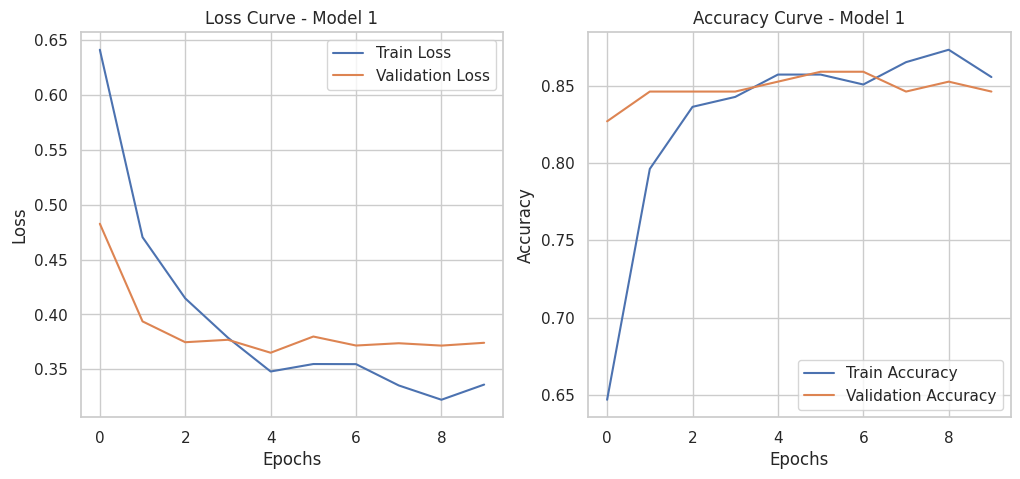

In [77]:
# Mô hình thứ ba với hàm kích hoạt khác và Dropout (64-64-32-16 tanh + Dropout)
model_3 = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1, activation='sigmoid')
])

# Compile mô hình
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
history_3 = model_3.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

# Đánh giá mô hình
loss, accuracy = model_3.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy trên tập kiểm tra: {accuracy:.4f}")

# Vẽ biểu đồ loss và accuracy cho model_1
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve - Model 1')

plt.subplot(1, 2, 2)
plt.plot(history_3.history['accuracy'], label='Train Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve - Model 1')
plt.show()

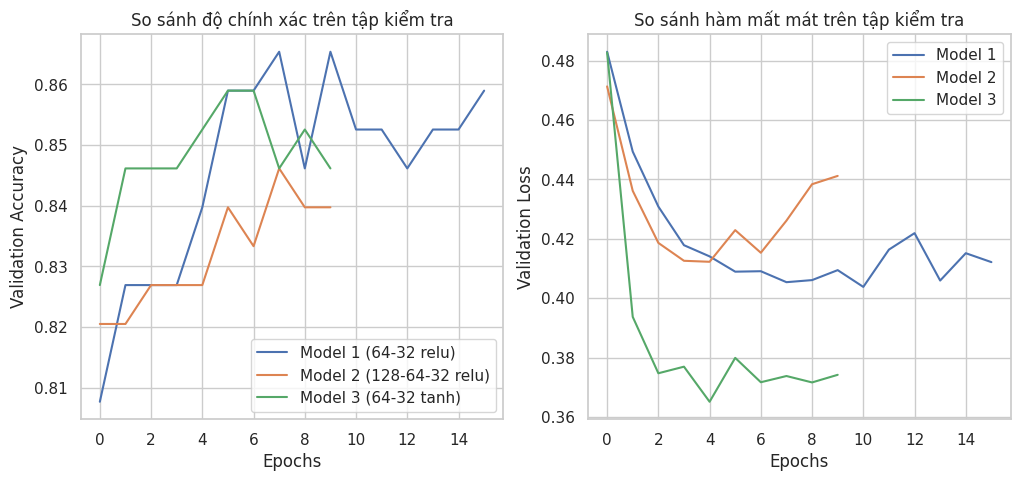

In [79]:
# So sánh kết quả
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['val_accuracy'], label='Model 1 (64-32 relu)')
plt.plot(history_2.history['val_accuracy'], label='Model 2 (128-64-32 relu)')
plt.plot(history_3.history['val_accuracy'], label='Model 3 (64-32 tanh)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('So sánh độ chính xác trên tập kiểm tra')

plt.subplot(1, 2, 2)
plt.plot(history_1.history['val_loss'], label='Model 1')
plt.plot(history_2.history['val_loss'], label='Model 2')
plt.plot(history_3.history['val_loss'], label='Model 3')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('So sánh hàm mất mát trên tập kiểm tra')
plt.show()